In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from ase.build import bulk
import catkit
import numpy as np
from time import perf_counter
from pathlib import Path

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] = "/home/pleon/mylammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.calculators import LAMMPSRunSurfCalc

from time import perf_counter

/home/dux/NeuralForceField/models


Initialize test slab and parameters

In [3]:
# Initialize paths
surface_name = "Cu(100)"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Cu alat from https://www.copper.org/resources/properties/atomic_properties.html
Cu_bulk = bulk("Cu", "fcc", a=3.6147)
slab = catkit.build.surface(
    Cu_bulk,
    size=(2, 2, 2),
    miller=(1, 0, 0),
    termination=0,
    fixed=0,
    vacuum=15.0,
    orthogonal=False,
)

calc_settings = {
    "calc_name": "eam",
    "optimizer": "FIRE",
    "chem_pots": {"Cu": 0.0},
    "relax_atoms": False,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "total_sweeps": 20,
    "sweep_size": 2,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": True,
    "alpha": 0.99,  # slowly anneal
    "adsorbates": ["Cu"],
    "run_folder": run_folder,
}

Get adsorption coordinates

In [4]:
pristine_slab = slab.copy()

from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)
ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=True,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 0.   ,  5.112, 18.307]), array([ 2.556,  3.834, 18.307])]...


Set up LAMMPS (calculator)

In [5]:
# use LAMMPS
parameters = {"pair_style": "eam", "pair_coeff": ["* * Cu_u3.eam"]}

# set up the LAMMPS calculator
potential_file = Path(os.environ["LAMMPS_POTENTIALS"]) / "Cu_u3.eam"
lammps_surf_calc = LAMMPSRunSurfCalc(
    files=[potential_file],
    keep_tmp_files=False,
    keep_alive=False,
    tmp_dir=Path.home() / "vssr_tmp_files",
)
lammps_surf_calc.set(**parameters)

Initialize surface system

In [6]:
surface = SurfaceSystem(
    slab,
    ads_positions,
    calc=lammps_surf_calc,
    system_settings=system_settings,
    default_io_path=run_folder,
)
surface.all_atoms.write(run_folder / "Cu_100_2x2x2_all_virtual_ads.cif")

2024-06-28 15:31:43,790|INFO|initializing 2 virtual atoms
2024-06-28 15:31:43,793|INFO|Initial state is [0 0]
2024-06-28 15:31:43,794|INFO|Number of pristine atoms is 8
2024-06-28 15:31:43,796|INFO|bulk indices are [0 1 2 3]
2024-06-28 15:31:43,797|INFO|surface indices are [4 5 6 7]
2024-06-28 15:31:43,797|INFO|constraints are FixAtoms(indices=[0, 1, 2, 3])


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `Cu(100)/` folder.

2024-06-28 15:31:43,847|INFO|Running with num_sweeps = 20, sweep_size = 2, start_temp = 1.000
2024-06-28 15:31:43,850|INFO|There are 8 atoms in pristine slab


2024-06-28 15:31:43,872|INFO|Initial energy is -24.058
2024-06-28 15:31:43,873|INFO|Using user specified run folder Cu(100)
2024-06-28 15:31:44,123|INFO|Starting with iteration 0
2024-06-28 15:31:44,124|INFO|Temperature schedule is: ['1.000', '0.990', '0.980', '0.970', '0.961', '0.951', '0.941', '0.932', '0.923', '0.914', '0.904', '0.895', '0.886', '0.878', '0.869', '0.860', '0.851', '0.843', '0.835', '0.826']
2024-06-28 15:31:44,125|INFO|In sweep 1 out of 20
2024-06-28 15:31:44,190|INFO|optim structure has Energy = -25.289
2024-06-28 15:31:44,192|INFO|In sweep 2 out of 20
2024-06-28 15:31:44,257|INFO|optim structure has Energy = -25.289
2024-06-28 15:31:44,260|INFO|In sweep 3 out of 20
2024-06-28 15:31:44,326|INFO|optim structure has Energy = -25.289
2024-06-28 15:31:44,328|INFO|In sweep 4 out of 20
2024-06-28 15:31:44,401|INFO|optim structure has Energy = -25.289
2024-06-28 15:31:44,404|INFO|In sweep 5 out of 20
2024-06-28 15:31:44,446|INFO|optim structure has Energy = -25.289
2024-0

Time taken = 1.825 seconds


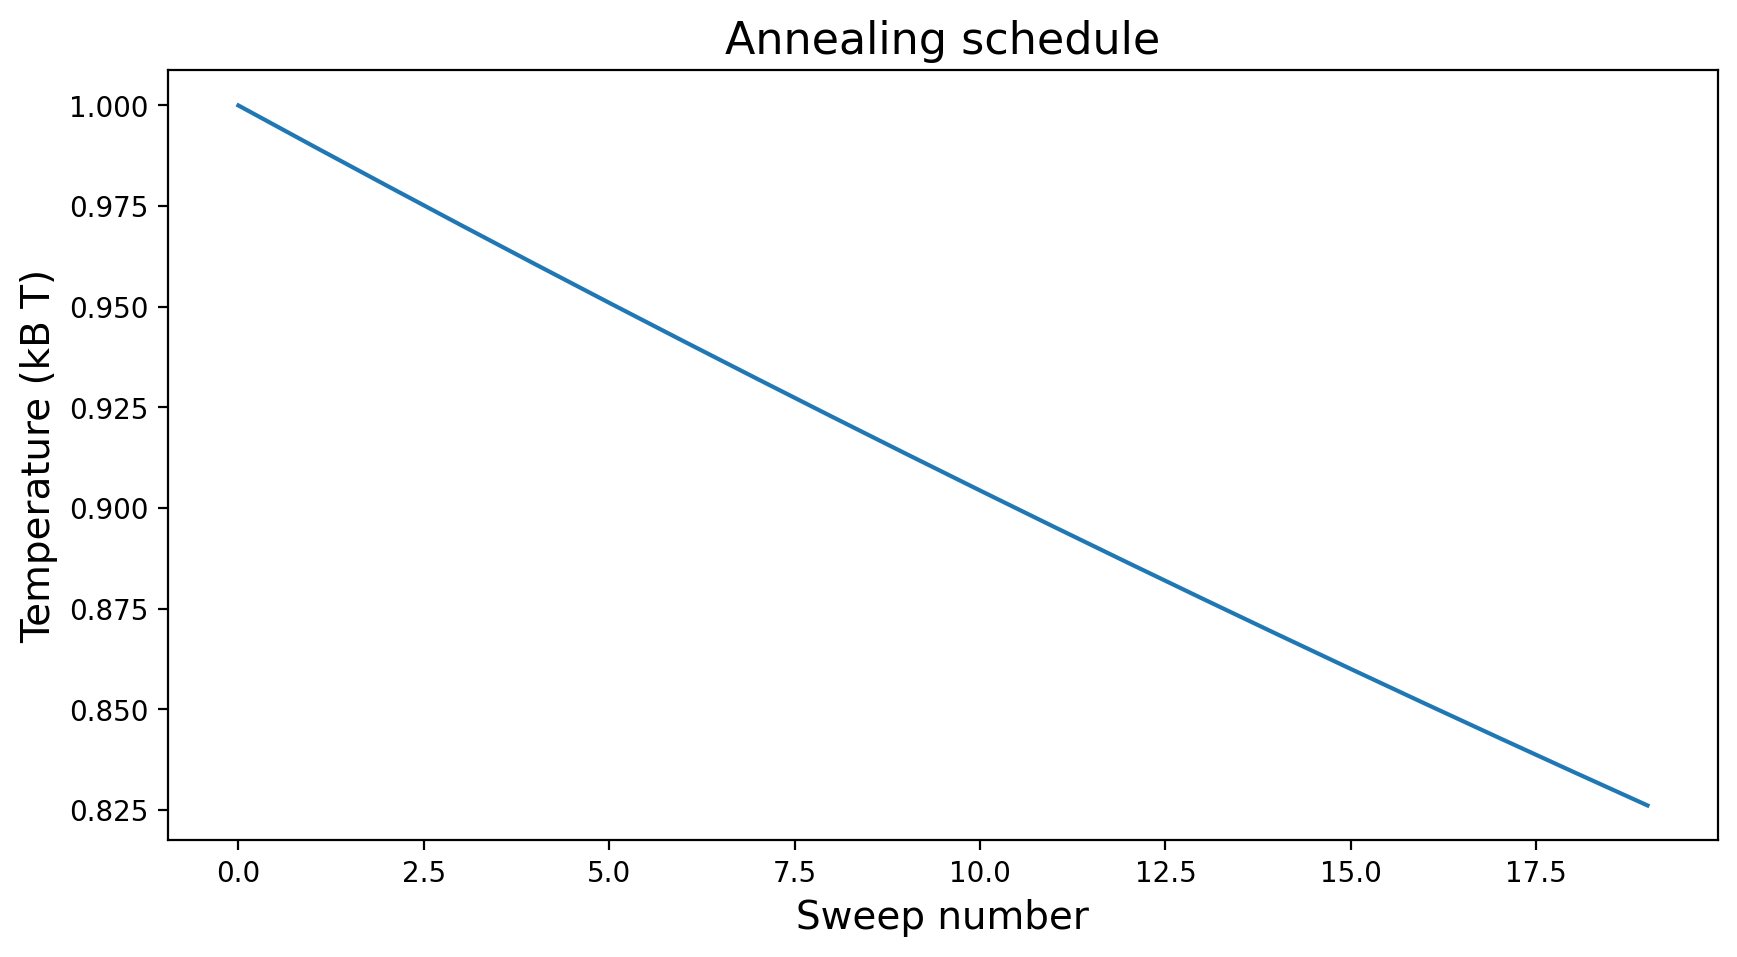

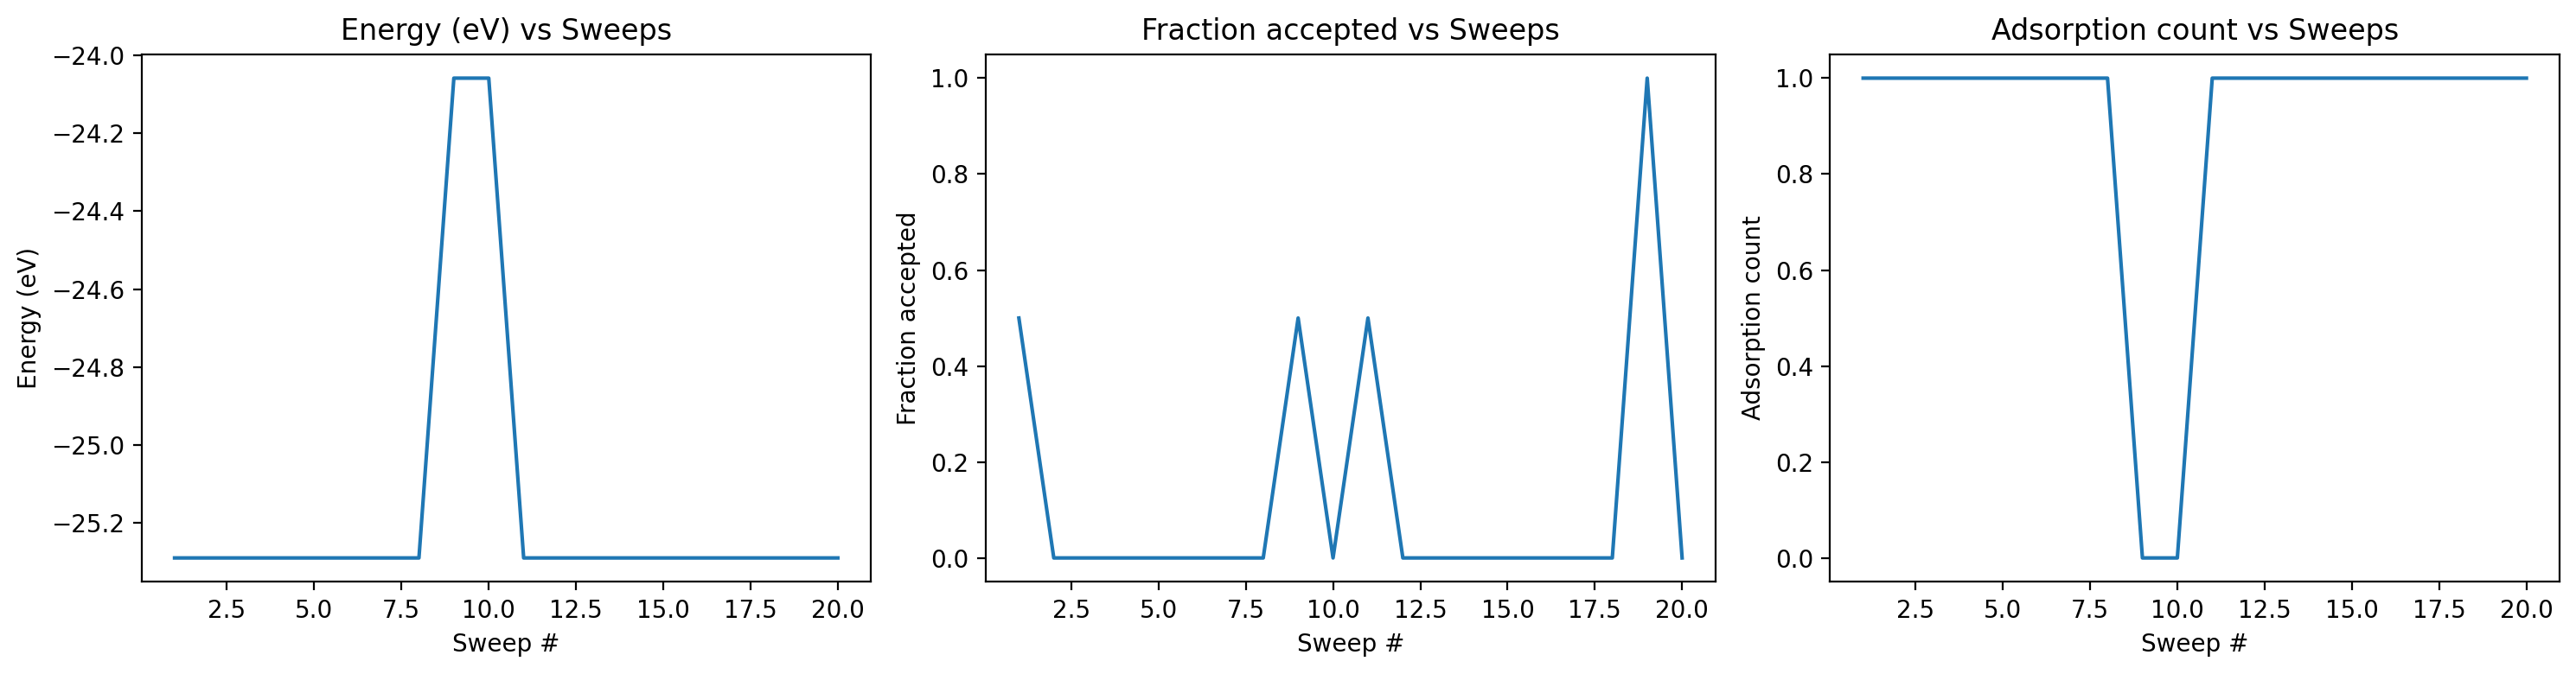

In [7]:
mcmc = MCMC(
    **sampling_settings,
    relax=calc_settings["relax_atoms"],
)  # no relaxation

start = perf_counter()
mcmc.mcmc_run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")